# Colorisation d'image (Noir et blanc)

Le but de ce TP est de mettre en place une colorisation automatique de photo en noir et blanc

## Formats d'image

De nombreux très nombreux formats de stockage d'image en couleur sont possible sur 3 ou 4 canals je vous laisse regarder ici (doc de CV2) qulques formules de conversion.

https://docs.opencv.org/4.2.0/de/d25/imgproc_color_conversions.html


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

Récupération d'une image pour tester (appel d'une commande unix en local

In [ ]:
!wget 'https://www.dreamyachtcharter.com/wp-content/uploads/2019/03/dyc_ourdays_cuba_web-8-377x207.jpg'

--2021-04-09 12:21:15--  https://www.dreamyachtcharter.com/wp-content/uploads/2019/03/dyc_ourdays_cuba_web-8-377x207.jpg
Resolving www.dreamyachtcharter.com (www.dreamyachtcharter.com)... 35.214.136.247
Connecting to www.dreamyachtcharter.com (www.dreamyachtcharter.com)|35.214.136.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13380 (13K) [image/jpeg]
Saving to: 'dyc_ourdays_cuba_web-8-377x207.jpg.4'

dyc_ourdays_cuba_we 100%[===================>]  13.07K  --.-KB/s    in 0s      

2021-04-09 12:21:15 (85.2 MB/s) - 'dyc_ourdays_cuba_web-8-377x207.jpg.4' saved [13380/13380]



cv2 lit les images en format GRB par défaut !

(207, 377, 3)
(207, 377)


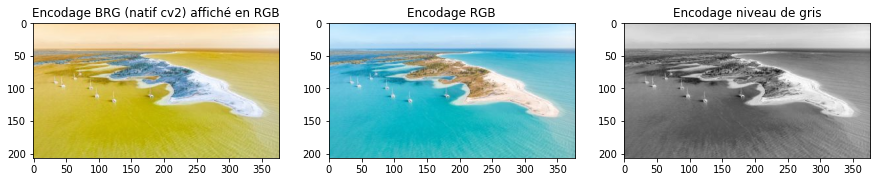

In [ ]:
image = cv2.imread('dyc_ourdays_cuba_web-8-377x207.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
print(image_gray.shape)
fig=plt.figure(figsize=(15, 8))
fig.add_subplot(1,3, 1)
plt.title('Encodage BRG (natif cv2) affiché en RGB')
plt.imshow(image)
fig.add_subplot(1,3, 2)
plt.title('Encodage RGB')
plt.imshow(image_rgb)
fig.add_subplot(1,3, 3)
plt.title('Encodage niveau de gris')
plt.imshow(image_gray,cmap='gray')

## Format Lab (Light, Green-to-Red, Blue-to-Yellow) (0:255,0:255,0:255)

la couche L (Ligthness) donne la luminosité de l'image, a et b sont des composantes de chrominance (la couleur).
a de vert à rouge et b de bleu à jaune.

sur notre exemple : 

(207, 377, 3)


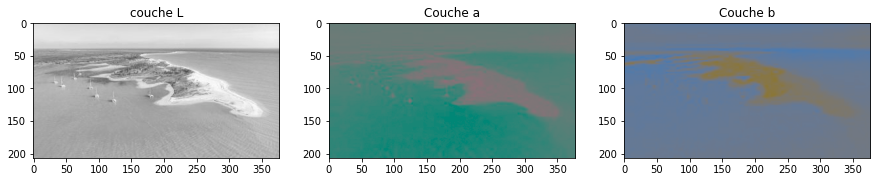

In [ ]:
image_Lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
print(image_Lab.shape)
fig=plt.figure(figsize=(15, 8))
## Affichage L (on repasse en RGB noté les valeur des couches a et b à 128)
fig.add_subplot(1,3, 1)
plt.title('couche L')
image_L = image_Lab.copy()
image_L[:,:,1:]=128
image_L = cv2.cvtColor(image_L, cv2.COLOR_LAB2RGB)
plt.imshow(image_L)
## Affichage a (on repasse en RGB noté les valeurs L et b à 128)
fig.add_subplot(1,3, 2)
plt.title('Couche a')
image_a = image_Lab.copy()
image_a[:,:,0]=128
image_a[:,:,2]=128
image_a = cv2.cvtColor(image_a, cv2.COLOR_LAB2RGB)
plt.imshow(image_a)
## Affichage a (on repasse en RGB noté les valeurs L et a à 128)
fig.add_subplot(1,3, 3)
plt.title('Couche b')
image_b = image_Lab.copy()
image_b[:,:,0]=128
image_b[:,:,1]=128
image_b = cv2.cvtColor(image_b, cv2.COLOR_LAB2RGB)
plt.imshow(image_b)

## Dataset CIFAR100 (images couleurs 32x32x3)

L' ensemble de données CIFAR-100 (Institut canadien de recherche avancée, 100 classes) est un sous-ensemble de l'ensemble de données "Tiny Images" et se compose de 60000 images couleur 32x32. Les 100 classes du CIFAR-100 sont regroupées en 20 superclasses. Il y a 600 images par classe. Chaque image est livrée avec une étiquette "fine" (la classe à laquelle elle appartient) et une étiquette "grossière" (la superclasse à laquelle elle appartient). Il y a 500 images de formation et 100 images de test par classe.

Nous nous serviront de cet ensemble suffisemment riche pour colorier nos images.

Nous alons procéder en 2 temps chaque image de taille 32x32x3 est encodée au Format Lab ensuite nous gardons le canal L comme entrée du réseau et prédirons les canaux ab.

Les données sont normalisée normalisées, (il faudra post-traiter pour visualiser).
* L entre 0 et 1
* a entre -1 et 1 (utiliser tanh comme fonction d'activation)
* b entre -1 et 1 (utiliser tanh comme fonction d'activation)


In [ ]:
from keras.datasets import cifar100
# on ne récupère pas les labels
(x_train, _), (x_test, _) = cifar100.load_data()

In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
x_test.shape

(10000, 32, 32, 3)

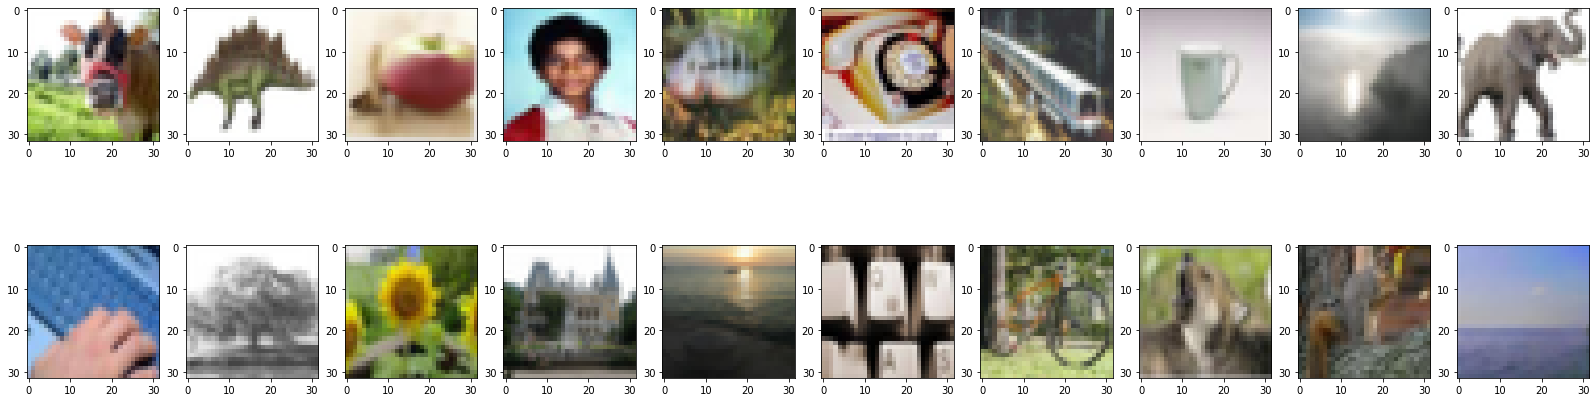

In [ ]:
fig=plt.figure(figsize=(28, 8))
n=20
start=0
for i in range(0, n):
    fig.add_subplot(2,10,i+1)
    plt.imshow(x_train[i+start])
plt.show()

## Mise en place du jeux de donnée

X et Y comme ensemble d'entrainement et Xt et Yt comme ensemble test

### Calcul X et Y (set apprentissage)

In [ ]:
X=[]
Y=[]
for i in range(0,x_train.shape[0]):
    im=x_train[i]
    im=cv2.cvtColor(im, cv2.COLOR_RGB2LAB)
    X.append(np.float32(im[:,:,0:1])/255)
    Y.append(np.float32(im[:,:,1:])/128-1)
X=np.array(X)
Y=np.array(Y)

In [ ]:
X.shape

(50000, 32, 32, 1)

### Calcul Xt et Yt (set de test)

In [ ]:
Xt=[]
Yt=[]
for i in range(0,x_test.shape[0]):
    im=x_test[i]
    im=cv2.cvtColor(im, cv2.COLOR_RGB2LAB)
    Xt.append(np.float32(im[:,:,0:1])/255)
    Yt.append(np.float32(im[:,:,1:])/128-1)
Xt=np.array(Xt)
Yt=np.array(Yt)

In [ ]:
Xt.shape

(10000, 32, 32, 1)

## Principe 

Partie encoder : extraie les caractéristiques des images encoder identique pour de la classification d'image

Partie decoder : reconstruit les couches de couleur à partir des caractéristiques

![](https://xiangyutang2.github.io/auto-colorization-autoencoders/autoencoder.png)

Exemple simple :

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import datasets, layers, models, losses, Sequential, Model

In [ ]:
#Design the neural network
model = Sequential()
# encoder
model.add(layers.InputLayer(input_shape=(32, 32 ,1)))
model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
# decoder
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(layers.UpSampling2D((2, 2)))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 8)         584       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 16)          2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 32)          9248      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 64)          1

In [ ]:
model.compile(optimizer='rmsprop',loss='mse',metrics=["accuracy"])

In [ ]:
history = model.fit(x=X, y=Y, validation_data=(Xt, Yt), batch_size=100, epochs=200, verbose=1)

Epoch 1/100
500/500 [==============================] - 31s 58ms/step - loss: 0.0157 - accuracy: 0.5903 - val_loss: 0.0152 - val_accuracy: 0.5980
Epoch 2/100
500/500 [==============================] - 26s 53ms/step - loss: 0.0150 - accuracy: 0.5994 - val_loss: 0.0149 - val_accuracy: 0.6020
Epoch 3/100
500/500 [==============================] - 26s 52ms/step - loss: 0.0149 - accuracy: 0.6030 - val_loss: 0.0150 - val_accuracy: 0.6145
Epoch 4/100
500/500 [==============================] - 26s 52ms/step - loss: 0.0145 - accuracy: 0.6074 - val_loss: 0.0147 - val_accuracy: 0.6062
Epoch 5/100
500/500 [==============================] - 26s 52ms/step - loss: 0.0142 - accuracy: 0.6125 - val_loss: 0.0143 - val_accuracy: 0.6155
Epoch 6/100
500/500 [==============================] - 26s 51ms/step - loss: 0.0141 - accuracy: 0.6186 - val_loss: 0.0141 - val_accuracy: 0.6266
Epoch 7/100
500/500 [==============================] - 26s 51ms/step - loss: 0.0139 - accuracy: 0.6187 - val_loss: 0.0140 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


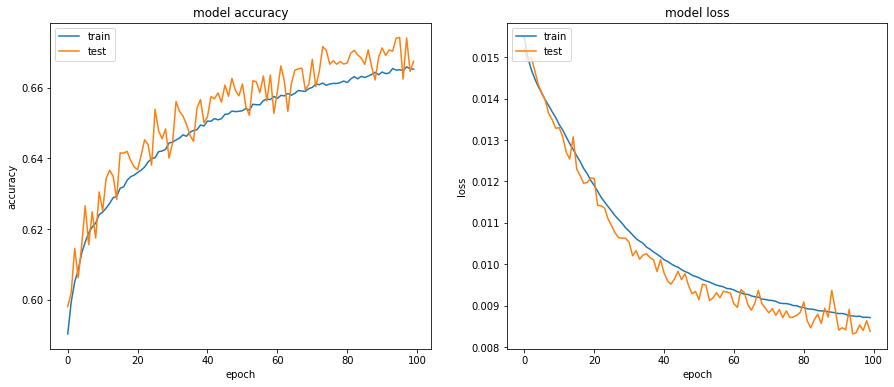

In [ ]:
print(history.history.keys())
fig=plt.figure(figsize=(15, 6))
# summarize history for accuracy
fig.add_subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
fig.add_subplot(1,2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Reconstruction et visualisation de la colorisation

In [ ]:
# calcul de la prédiction (long)
Y_p  = model.predict(X)
Yt_p = model.predict(Xt)

In [ ]:
# conversion de la prédiction
# enseble d'apprentissage
Imag_p=[]
for i in range(0,len(X)):
    im=np.zeros((32,32,3),np.uint8)
    im[:,:,0:1]=np.uint8(X[i]*255)
    im[:,:,1:]=np.uint8((Y_p[i][:,:,0:]+1)*128)
    image=cv2.cvtColor(im, cv2.COLOR_LAB2RGB)
    Imag_p.append(image)
# Ensemble test
Imagt_p=[]
for i in range(0,len(Xt)):
    im=np.zeros((32,32,3),np.uint8)
    im[:,:,0:1]=np.uint8(Xt[i]*255)
    im[:,:,1:]=np.uint8((Yt_p[i][:,:,0:]+1)*128)
    image=cv2.cvtColor(im, cv2.COLOR_LAB2RGB)
    Imagt_p.append(image)

## Sur Ensemble apprentissage

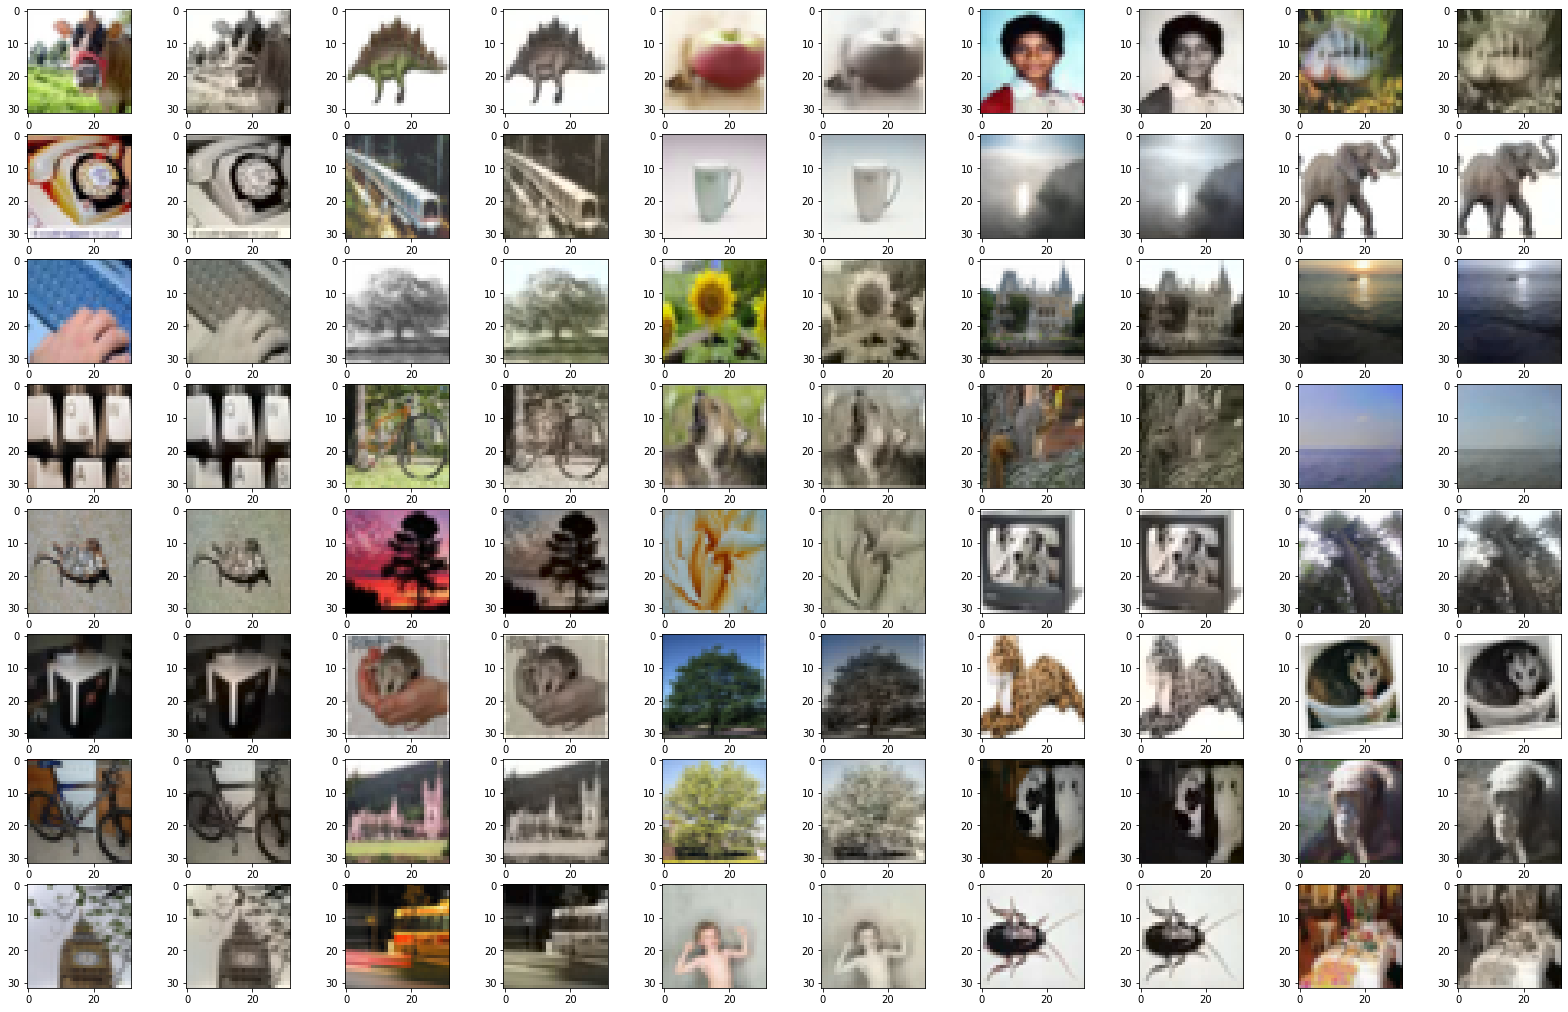

In [ ]:
fig=plt.figure(figsize=(28, 18))
n=40 # multiple de 5 pour 8 lignes
start=0
for i in range(0, n):
    fig.add_subplot(8,10, 2*i+1)
    plt.imshow(x_train[i+start])
    fig.add_subplot(8,10, 2*i+2)
    plt.imshow(Imag_p[i+start])
plt.show()

## Sur ensemble test

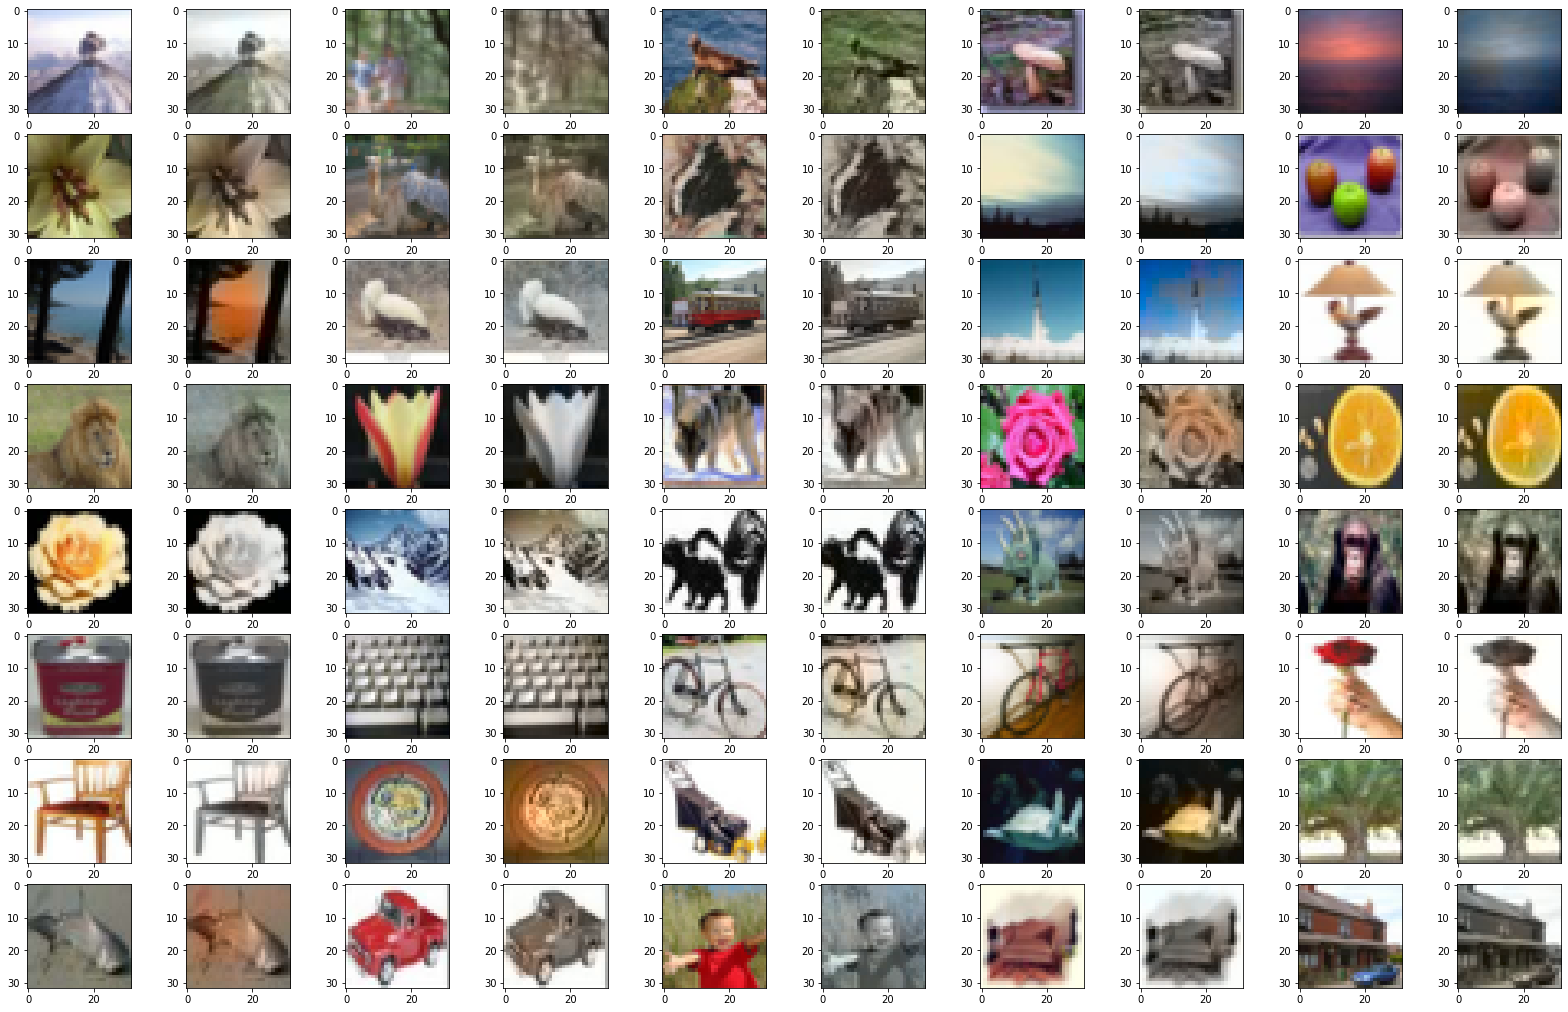

In [ ]:
fig=plt.figure(figsize=(28, 18))
n=40
start=0
for i in range(0, n):
    fig.add_subplot(8,10, 2*i+1)
    plt.imshow(x_test[i+start])
    fig.add_subplot(8, 10, 2*i+2)
    plt.imshow(Imagt_p[i+start])
plt.show()

# Utilisation d'un encoder pré-déterminer

Popur une liste complète d'encoder avec leur "accuracy" sur ImageNet et autre :

https://keras.io/api/applications/

Il est possible de choisir un réseau moins gourmand...

**Attention l'entrée ne peut être que 32x32x3 !**

In [ ]:
#base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
base_model = tf.keras.applications.ResNet50(include_top = False, input_shape = (32,32,3))
#base_model = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (32,32,3))
#for layer in base_model.layers:
#  layer.trainable = False
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(base_model.output)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(2, (3, 3), activation='tanh', padding='same')(x)
model=Model(inputs = base_model.input, outputs = x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop',loss='mse',metrics=["accuracy"])

# Modification des éléments d'entrée
On va pousser une image noir et blanc (possible de faire varier cette étape)

In [ ]:
Xnew=[]
for i in range(0,len(X)):
    tmp=np.zeros((32,32,3))
    tmp[:,:,0]=X[i][:,:,0]
    tmp[:,:,1]=X[i][:,:,0]
    tmp[:,:,2]=X[i][:,:,0]
    Xnew.append(tmp)
Xnew= np.array(Xnew)

Xtnew=[]
for i in range(0,len(Xt)):
    tmp=np.zeros((32,32,3))
    tmp[:,:,0]=Xt[i][:,:,0]
    tmp[:,:,1]=Xt[i][:,:,0]
    tmp[:,:,2]=Xt[i][:,:,0]
    Xtnew.append(tmp)
Xtnew= np.array(Xtnew)

### Calcul avec ResNet50

In [ ]:
#Train the neural network
history = model.fit(x=Xnew, y=Y, validation_data=(Xtnew, Yt), batch_size=100, epochs=100, verbose=1)

Epoch 1/100
500/500 [==============================] - 2694s 5s/step - loss: 0.0165 - accuracy: 0.5929 - val_loss: 0.0214 - val_accuracy: 0.4930
Epoch 2/100
500/500 [==============================] - 2657s 5s/step - loss: 0.0147 - accuracy: 0.6074 - val_loss: 0.0153 - val_accuracy: 0.5985
Epoch 3/100
500/500 [==============================] - 2638s 5s/step - loss: 0.0136 - accuracy: 0.6196 - val_loss: 0.0142 - val_accuracy: 0.6135
Epoch 8/100
500/500 [==============================] - 2640s 5s/step - loss: 0.0134 - accuracy: 0.6207 - val_loss: 0.0146 - val_accuracy: 0.6057
Epoch 9/100
500/500 [==============================] - 2650s 5s/step - loss: 0.0132 - accuracy: 0.6246 - val_loss: 0.0199 - val_accuracy: 0.5997
Epoch 10/100
500/500 [==============================] - 2632s 5s/step - loss: 0.0120 - accuracy: 0.6458 - val_loss: 0.0149 - val_accuracy: 0.6166
Epoch 15/100
500/500 [==============================] - 2640s 5s/step - loss: 0.0101 - accuracy: 0.6646 - val_loss: 0.0151 - val_

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 2628s 5s/step - loss: 0.0054 - accuracy: 0.7529 - val_loss: 0.0150 - val_accuracy: 0.6258
Epoch 84/100
500/500 [==============================] - 2656s 5s/step - loss: 0.0054 - accuracy: 0.7530 - val_loss: 0.0167 - val_accuracy: 0.6270
Epoch 85/100
500/500 [==============================] - 2652s 5s/step - loss: 0.0054 - accuracy: 0.7551 - val_loss: 0.0156 - val_accuracy: 0.6265
Epoch 86/100
500/500 [==============================] - 2639s 5s/step - loss: 0.0054 - accuracy: 0.7560 - val_loss: 0.0150 - val_accuracy: 0.6180
Epoch 87/100
500/500 [==============================] - 2623s 5s/step - loss: 0.0053 - accuracy: 0.7592 - val_loss: 0.0151 - val_accuracy: 0.6287
Epoch 88/100
500/500 [==============================] - 2655s 5s/step - loss: 0.0052 - accuracy: 0.7563 - val_loss: 0.0159 - val_accuracy: 0.6215
Epoch 89/100
500/500 [==============================] - 2625s 5s/step - loss: 0.0052 - accuracy: 0.7568 - val_loss: 0.0151 - val_accuracy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


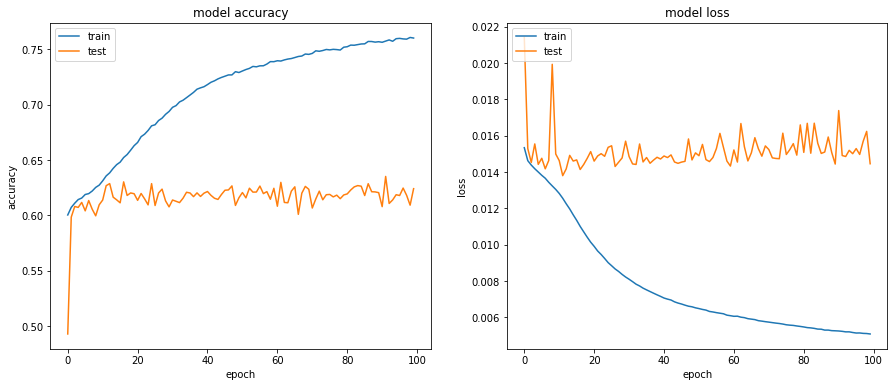

In [ ]:
print(history.history.keys())
fig=plt.figure(figsize=(15, 6))
# summarize history for accuracy
fig.add_subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
fig.add_subplot(1,2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# calcul de la prédiction (long)
Y_p  = model.predict(Xnew)
Yt_p = model.predict(Xtnew)

In [ ]:
# conversion de la prédiction
# enseble d'apprentissage
Imag_p=[]
for i in range(0,len(X)):
    im=np.zeros((32,32,3),np.uint8)
    im[:,:,0:1]=np.uint8(X[i]*255)
    im[:,:,1:]=np.uint8((Y_p[i][:,:,0:]+1)*128)
    image=cv2.cvtColor(im, cv2.COLOR_LAB2RGB)
    Imag_p.append(image)
# Ensemble test
Imagt_p=[]
for i in range(0,len(Xt)):
    im=np.zeros((32,32,3),np.uint8)
    im[:,:,0:1]=np.uint8(Xt[i]*255)
    im[:,:,1:]=np.uint8((Yt_p[i][:,:,0:]+1)*128)
    image=cv2.cvtColor(im, cv2.COLOR_LAB2RGB)
    Imagt_p.append(image)

### Ensemble apprentissage

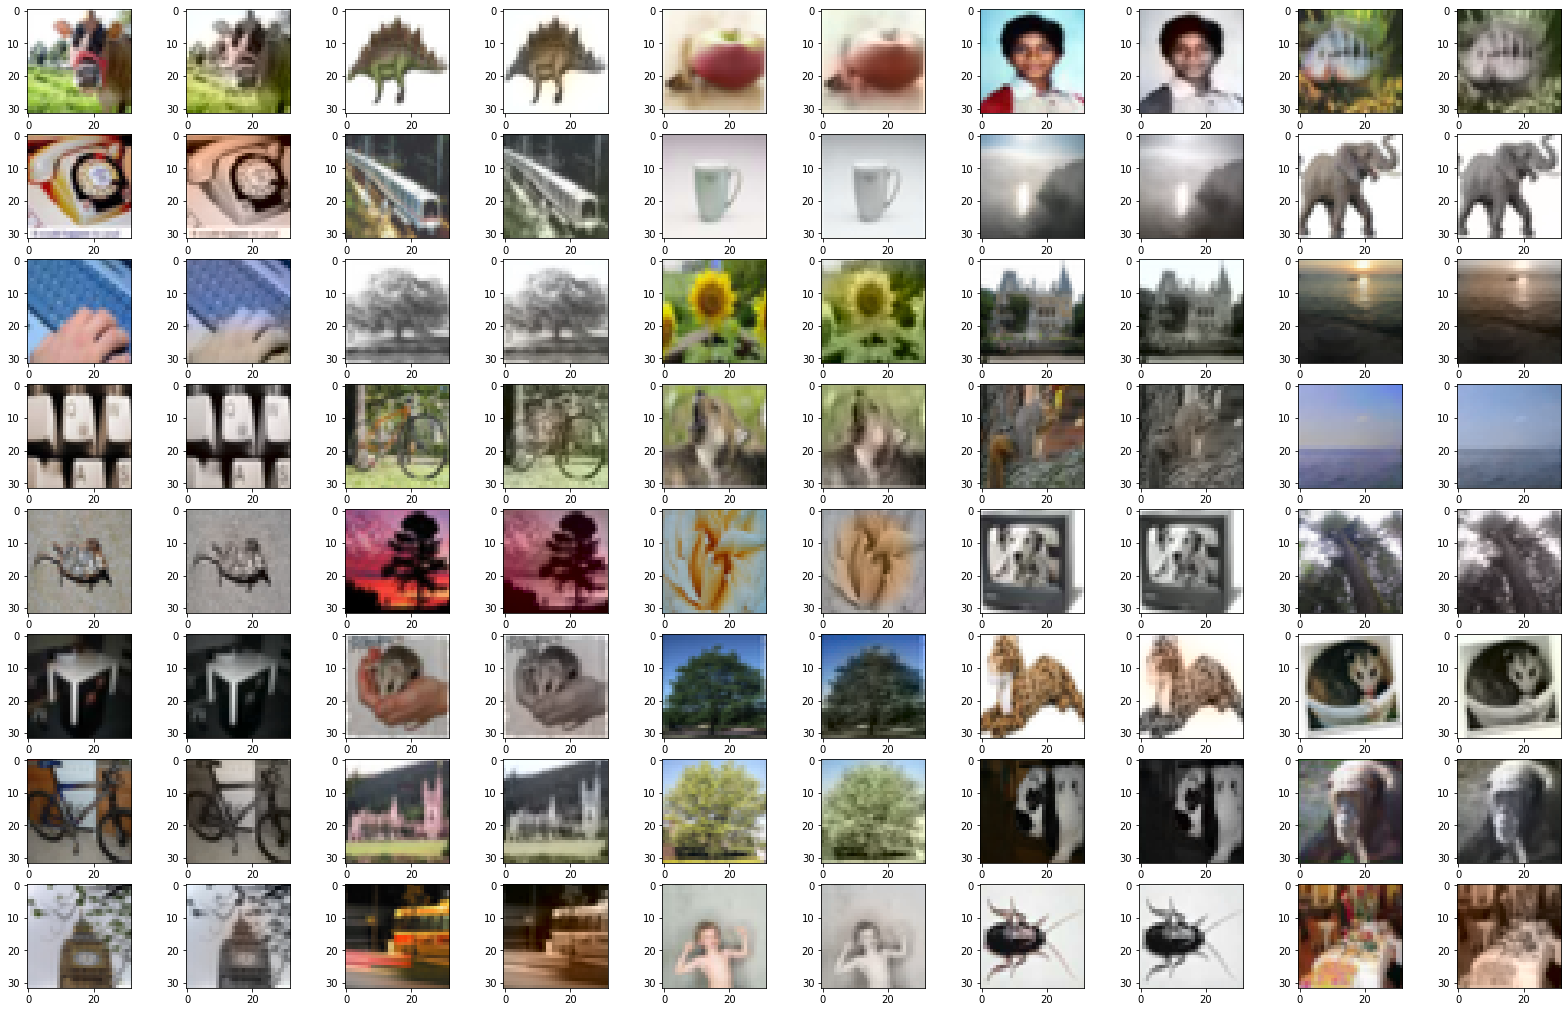

In [ ]:
fig=plt.figure(figsize=(28, 18))
n=40 # multiple de 5 pour 8 lignes
start=0
for i in range(0, n):
    fig.add_subplot(8,10, 2*i+1)
    plt.imshow(x_train[i+start])
    fig.add_subplot(8,10, 2*i+2)
    plt.imshow(Imag_p[i+start])
plt.show()

### Ensemble test

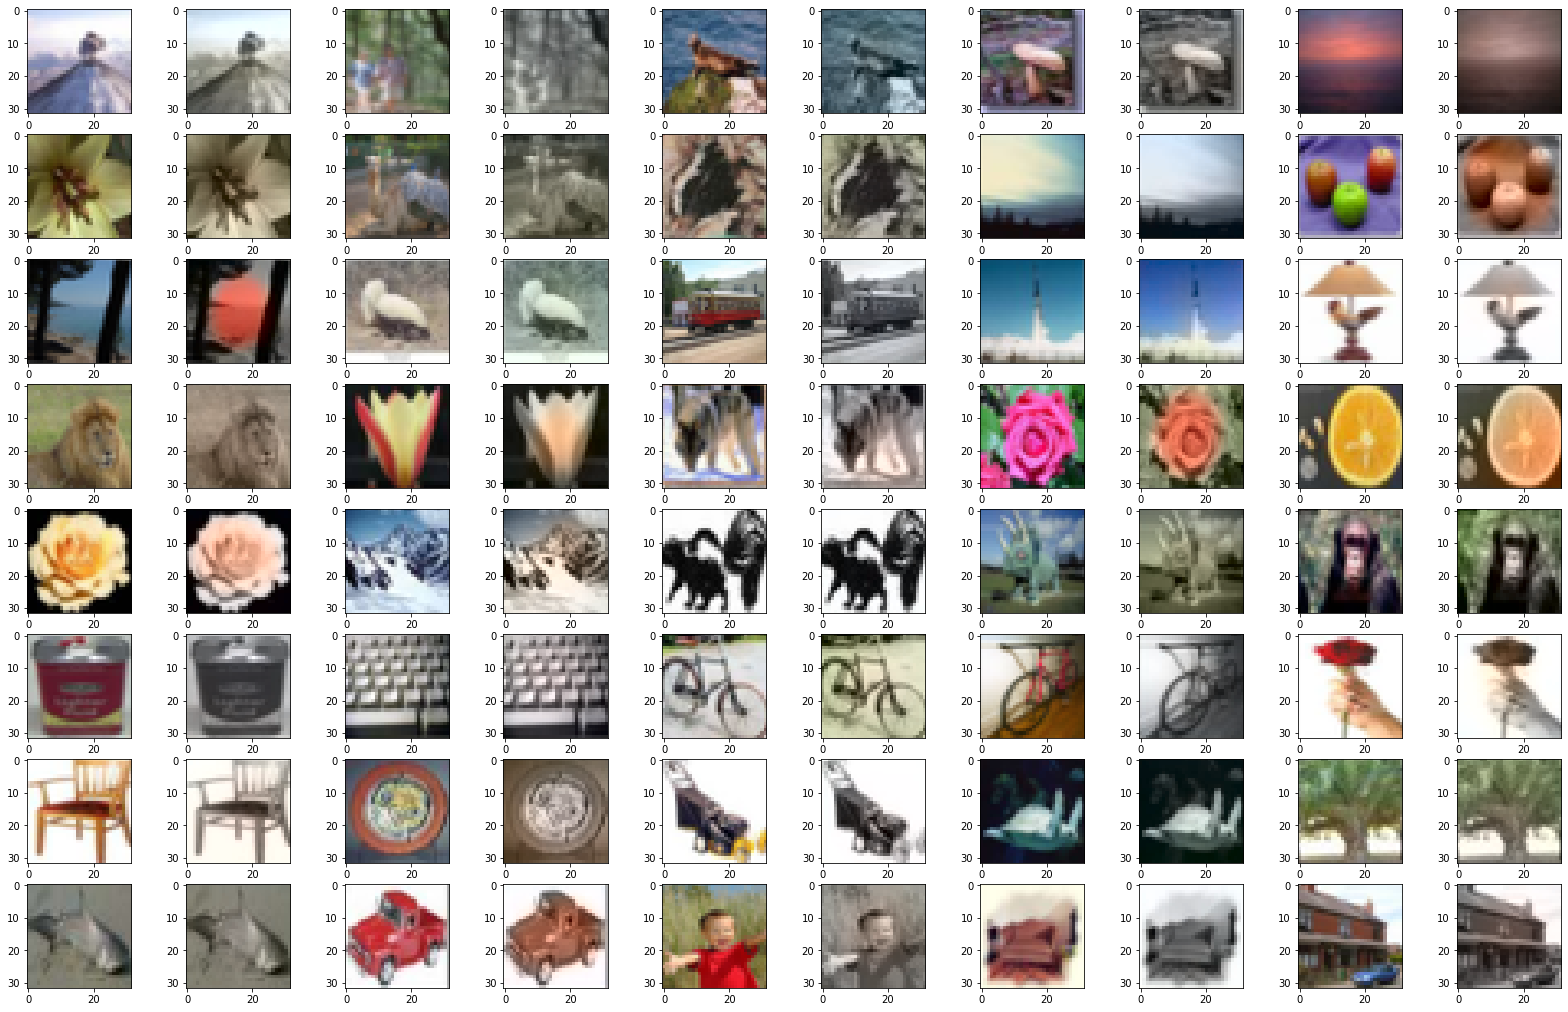

In [ ]:
fig=plt.figure(figsize=(28, 18))
n=40 # multiple de 5 pour 8 lignes
start=0
for i in range(0, n):
    fig.add_subplot(8,10, 2*i+1)
    plt.imshow(x_test[i+start])
    fig.add_subplot(8,10, 2*i+2)
    plt.imshow(Imagt_p[i+start])
plt.show()